color_maprow## Introduction

### What causes risks for cycling?

Perception of risk impedes people from cycling. This project's goal is to build an AI model to estimate a
score of perceived road safety based on Google Street View images.

According to the literature, to maintain the highest level of safety on the roads, cyclists should avoid hazards or situations to avoid that may cause them to fall, like toys, pebbles, potholes, grates, train tracks.(in: https://www.nhtsa.gov/road-safety/bicycle-safety)

Infrastructure quality and layout play a role in the occurrence and outcome of bicycle crashes. Road surface that suffers from pits, trenches, drain covers, tree root encroachments, etc., is often the reason for a single-bicycle crash (SWOV 2017). Visibility of obstacles, the road course and the width of bicycle paths and lanes also add to the crash risk. 

### What did we do here?

Starting from a very open problem - where all that is asked is to predict road street quality - we tried to create a set of models that would give us some objective measure of risk level.

TBD



## Development

In [1]:
# !pip install reverse_geocoder
# !pip3 install tensorflow
# !pip install opencv-contrib-python
# !pip install cvlib
# !pip install tensorflow==2.0.0
# !pip install folium

# Import packages

import pandas as pd
import numpy as np
import os
import re
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import pickle

import folium

#imports for deep learning
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, regularizers, Input, losses, metrics
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit


# Imports
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox
import requests
from geopy.geocoders import Nominatim

# imports ipywidgets
from ipywidgets import HTML
import plotly.graph_objs as go
from ipywidgets import Image, Layout
from ipywidgets import HBox, VBox

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Get mapping between coordinates text files and image names

In [2]:
def get_mapping_name_coords(data_path):
    """
    This function uses the coordinates.txt files to map an image name to its coordinates, as a tuple, in a Pandas Dataframe.
    
    Input example: lat:38.76039827177381;lng-9.190202095966573

    Args:
        data_path (str): The path containing the coordinates cada.
        
    Returns:
        (pd.DataFrame): A Dataframe containing two columns: image name and corresponding coordinates.
    """
    coordinates_files = os.listdir(data_path)

    mapping_name_coords = []

    for file in coordinates_files:
        with open(data_path + file, 'r') as f:
            content = f.read()
            content_split = content.split(';')
            
            # Pre-process text to retain only latitude and longitude.
            lat = re.sub("[^0-9.-]", "", content_split[0])
            long = re.sub("[^0-9.-]", "", content_split[1])

            mapping_name_coords.append([file[:-4], (lat, long)])
    
    return pd.DataFrame(mapping_name_coords, columns=['name', 'coordinates'])

mapping_name_coords = get_mapping_name_coords('data/coordinates/')

Load cycling network, which was discovered in ArcGIS and contains the cycling networks in Lisbon

In [3]:
url = "https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/Ciclovias/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
ciclovias = requests.get(url).json()

ret = []
for row in ciclovias['features']:
    ret.append({
        'geometry': row['geometry']['paths'],
        'center_of_mass': np.mean(row['geometry']['paths'][0], axis=0),
        'tipologia': row['attributes']['TIPOLOGIA'],
        'DESIGNACAO': row['attributes']['DESIGNACAO']
    })
ciclovias_df = pd.DataFrame.from_dict(ret)
ciclovias_df['coordinates'] = ciclovias_df['center_of_mass'].apply(lambda x: (x[1], x[0]))
ciclovias_df['coordinates'] = ciclovias_df['coordinates'].astype(str)

In [4]:
def add_reverse_coords(df):
    """
    This function maps a coordinate pair into an actual location.
    This process is relatively slow, so the computation is done once below, and saved into a .csv. 
    
    Args:
        df (pd.DataFrame): Function containing a column 'coordinates' with a tuple of latitude, longitude.
        
    Returns:
        (pd.DataFrame): Dataframe witha dded suburb (parish), county and city.
    """
    locator = Nominatim(user_agent="google")

    reverse_coords = [
        locator.reverse(eval(x)).raw for x in list(df['coordinates'])
    ]
    df['freguesia'] = [x.get('address').get('suburb', "None") for x in reverse_coords]
    df['concelho'] = [x.get('address').get('county', "None") for x in reverse_coords]
    df['cidade'] = [x.get('address').get('city', "None") for x in reverse_coords]
    
    return df

In [5]:
load_from_cache = 1

if not load_from_cache:
    # This step is slow, should only run once
    mapping_name_coords = add_reverse_coords(mapping_name_coords)
    ciclovias_df = add_reverse_coords(ciclovias_df)
    ciclovias_df = ciclovias_df.drop_duplicates('DESIGNACAO').reset_index()
    ciclovias_df.to_csv('data/ciclovias_df.csv')
    mapping_name_coords.to_csv('data/mapping_name_coords.csv')
else:
    mapping_name_coords = pd.read_csv('data/mapping_name_coords.csv')
    ciclovias_df = pd.read_csv('data/ciclovias_df.csv')

In [6]:
mapping_name_coords.head(3)

Unnamed: 0     name                                  coordinates  \
0           0   image0     ('38.73277225961562', '-9.172048739336')   
1           1   image1  ('38.76039827177381', '-9.190202095966573')   
2           2  image10                 ('38.7439627', '-9.1136023')   

   freguesia concelho  cidade  
0  Campolide   Lisboa  Lisboa  
1    Carnide   Lisboa  Lisboa  
2    Marvila   Lisboa  Lisboa

In [7]:
ciclovias_df.head(3)

Unnamed: 0  index                                           geometry  \
0           0      0  [[[-9.09361178250349, 38.7829591923676], [-9.0...   
1           1      1  [[[-9.14832243430936, 38.747977409217], [-9.14...   
2           2      2  [[[-9.21314651900988, 38.6934096000848], [-9.2...   

              center_of_mass                    tipologia  \
0  [-9.09340148 38.78264149]        Percurso Ciclopedonal   
1  [-9.14821372 38.74799392]  Pista Ciclável Bidirecional   
2  [-9.21324434 38.69239135]  Pista Ciclável Bidirecional   

                   DESIGNACAO                               coordinates  \
0   Passeio dos Heróis do Mar  (38.782641494079876, -9.093401476864278)   
1                Campo Grande   (38.747993924972036, -9.14821372019368)   
2  Troço da Frente Ribeirinha   (38.69239134565385, -9.213244342304932)   

           freguesia concelho  cidade  
0  Parque das Nações   Lisboa  Lisboa  
1           Alvalade   Lisboa  Lisboa  
2              Belém   Lisboa  Lisboa

In [8]:
def swap_coords(df):
    """
    Swap latitude and longitude in cycling paths datafame

    Args:
        df (pd.DataFrame): Dataframe containing cycling lanes.

    Returns:
        (pd.DataFrame): Dataframe with an extra column (swapped_coords) where the latitude and longitude are swapped
    """
    swapped_coords = []

    for i, row in ciclovias_df.iterrows():
        geometry_original = eval(row.geometry)[0]

        geometry_new = [[x[1], x[0]] for x in geometry_original]
        swapped_coords.append(geometry_new)
    ciclovias_df['swapped_coords'] = swapped_coords
    
    return ciclovias_df

In [9]:
ciclovias_df = swap_coords(ciclovias_df)

In [10]:
ciclovias_df.head(3)

Unnamed: 0  index                                           geometry  \
0           0      0  [[[-9.09361178250349, 38.7829591923676], [-9.0...   
1           1      1  [[[-9.14832243430936, 38.747977409217], [-9.14...   
2           2      2  [[[-9.21314651900988, 38.6934096000848], [-9.2...   

              center_of_mass                    tipologia  \
0  [-9.09340148 38.78264149]        Percurso Ciclopedonal   
1  [-9.14821372 38.74799392]  Pista Ciclável Bidirecional   
2  [-9.21324434 38.69239135]  Pista Ciclável Bidirecional   

                   DESIGNACAO                               coordinates  \
0   Passeio dos Heróis do Mar  (38.782641494079876, -9.093401476864278)   
1                Campo Grande   (38.747993924972036, -9.14821372019368)   
2  Troço da Frente Ribeirinha   (38.69239134565385, -9.213244342304932)   

           freguesia concelho  cidade  \
0  Parque das Nações   Lisboa  Lisboa   
1           Alvalade   Lisboa  Lisboa   
2              Belém   Lisboa  Lisboa   

                                      swapped_coords  
0  [[38.7829591923676, -9.09361178250349], [38.78...  
1  [[38.747977409217, -9.14832243430936], [38.747...  
2  [[38.6934096000848, -9.21314651900988], [38.69...

### Represent Datapoints

The plot below shows a marker for the coordinates at which we have images (in red). We can see that the images were gathered in a short radius around Lisbon's airport, in an uniform way, comprising only a few km, so not much variance between the streets is to be expected.

We also show the cyclelanes in blue. It seems that the area chosen has a lot of cycle lanes.

In [11]:
import folium

mapping_name_coords['coordinates'] = mapping_name_coords['coordinates'].str.replace('(', '').str.replace(')', '').str.replace('\'', '')
mapping_name_coords[['latitude','longitude']] = mapping_name_coords.coordinates.str.split(",",expand=True,).astype(float)

m = folium.Map(location=[38.760398,-9.190202], zoom_start=13)

for indice, row in mapping_name_coords.iterrows():
      folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                          color="crimson", fill_color="crimson", tooltip=row["name"], fill=True,
                          radius=3).add_to(m)
        
for row in list(ciclovias_df['swapped_coords']):
    folium.PolyLine(locations=[row], color="blue", weight=2.5, opacity=1).add_to(m)
        
m

### Labeled Classes

We labeled the following classes in order to objectively classify pavement quality:

- Irrelevant view: whenever the street is fully visible or the image is just pointing to a wall
- Street width: a single car could fit the street vs more than one car could fit there
- Pavement Type: parallel (paralelo), tar (alcatrão) or dirt (terra batida)
- Pavement quality: For tar streets, whether or not it had:
    - No visible damage
    - Some visible cracks
    - Both cracks and patches/holes
    
Rules for annotation and modeling:

- Whenever image is "irrelevant", dont label anything else
- Whenever type is different from "alcatrão", don't label street quality

In [12]:
annotations = pd.read_csv('data/annotations_final.csv')

annotations['image'] = annotations['image'].apply(lambda x: x.split('/')[-1])
annotations['image_group'] = annotations.image.str.extract(r"(image\d{1,})")

annotations['irrelevant_infer'] = (annotations['street_width']=='irrelevant_image') * 1

In [13]:
annotations.head()

image   id        street_width                  annotator  \
0  image26angle180.jpg  135    irrelevant_image  paulomanuelmaia@gmail.com   
1  image13angle180.jpg   66  double_car_or_more  paulomanuelmaia@gmail.com   
2    image50angle0.jpg  249    irrelevant_image  paulomanuelmaia@gmail.com   
3   image50angle90.jpg  250  double_car_or_more  paulomanuelmaia@gmail.com   
4  image50angle180.jpg  251    irrelevant_image  paulomanuelmaia@gmail.com   

   annotation_id pavement_type pavement_quality image_group  irrelevant_infer  
0            135           NaN              NaN     image26                 1  
1             66      alcatrao              mid     image13                 0  
2            249           NaN              NaN     image50                 1  
3            250      alcatrao             high     image50                 0  
4            251           NaN              NaN     image50                 1

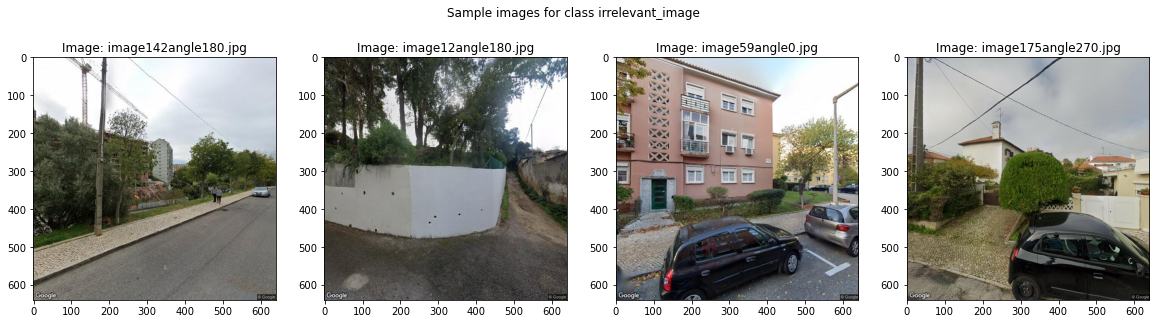

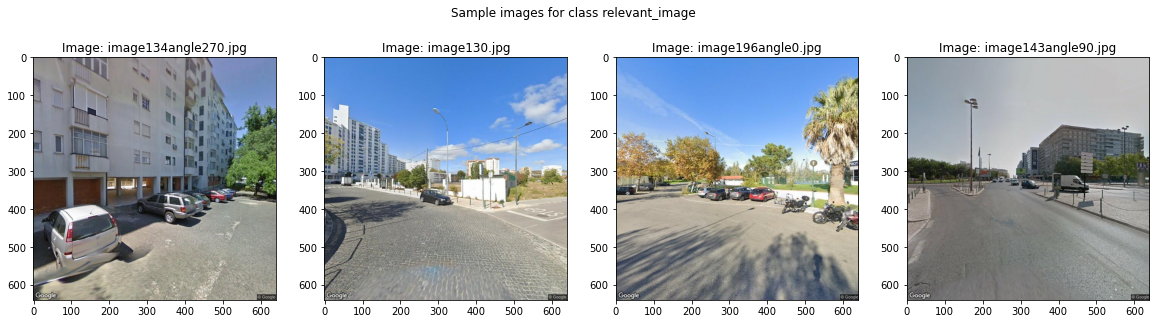

In [14]:
IMAGES_PATH = 'data/images/'
CLASS_NAME = 'irrelevant_image'

def make_plot(masked_df, CLASS_NAME, IMAGES_PATH):
    """
    This function takes a masked annotations dataframe (containing only the rows we want to consider)
        and plots 4 randomly selected images of that class.

    Args:
        masked_df (pd.DataFrame): Masked dataframe.
        CLASS_NAME (str): An indicator of the class name, for th etitle.
        IMAGES_PATH (str): The path containing the images.
    """
    images_name = list(masked_df.sample(5, replace=False)['image'])
    images = [plt.imread(IMAGES_PATH + x) for x in images_name]
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(images[i])
        plt.title('Image: {}'.format(images_name[i]))

    plt.suptitle(f'Sample images for class {CLASS_NAME}')
    plt.show()
    
make_plot(annotations[annotations['street_width'] == 'irrelevant_image'], 'irrelevant_image', IMAGES_PATH)
make_plot(annotations[annotations['street_width'] != 'irrelevant_image'], 'relevant_image', IMAGES_PATH)

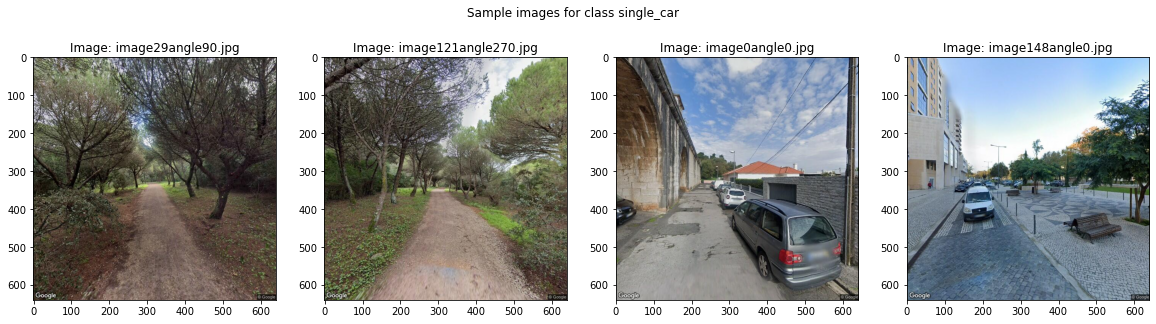

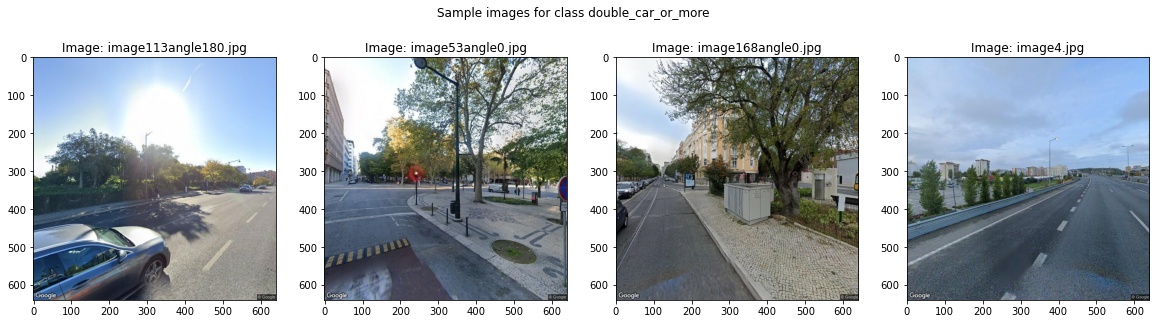

In [15]:
make_plot(annotations[annotations['street_width'] == 'single_car'], 'single_car', IMAGES_PATH)
make_plot(annotations[annotations['street_width'] == 'double_car_or_more'], 'double_car_or_more', IMAGES_PATH)

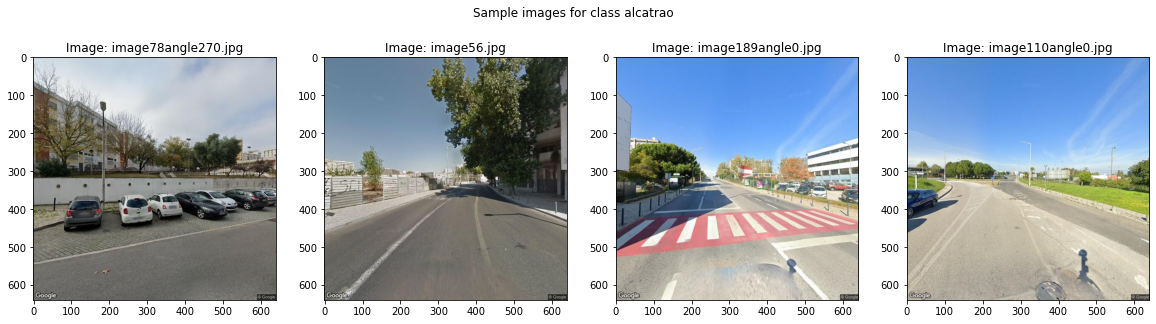

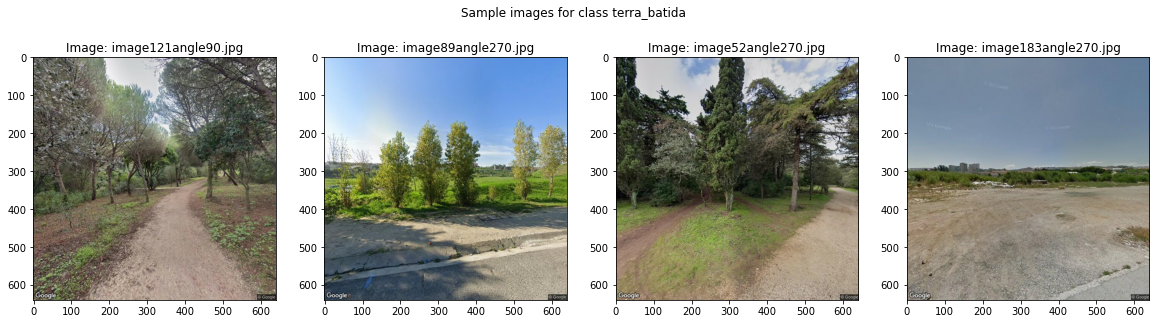

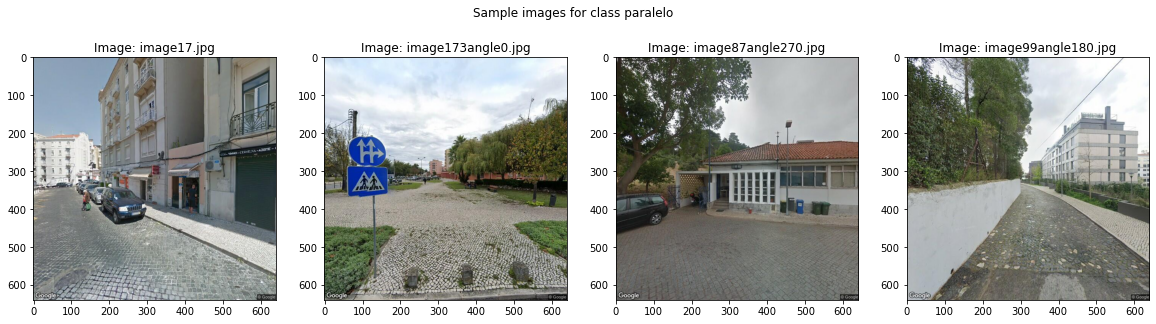

In [16]:
make_plot(annotations[annotations['pavement_type'] == 'alcatrao'], 'alcatrao', IMAGES_PATH)
make_plot(annotations[annotations['pavement_type'] == 'terra_batida'], 'terra_batida', IMAGES_PATH)
make_plot(annotations[annotations['pavement_type'] == 'paralelo'], 'paralelo', IMAGES_PATH)

### Deep Learning Models

##### Car Detection

The presence of detected cars/people in a certain region can be indicative of the risk level for cycling: regions with the presence of cars (either parked or driving) show that area has movement.

The absence does not indicate it doesn't - as the Street View images are taken at different times - but statistically, if a car appears there, it means there's more movement on average, compared to the areas without cars.

We used YOLO model to count the number of cars in all the dataset images. Below, just an example was shown, as this was pre-calculated separately. 

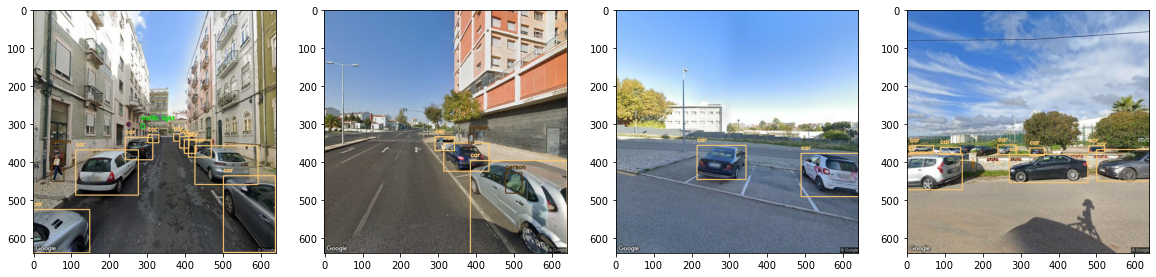

In [17]:
sample_images = [
    'aux_code/car_counter_kerastf/dset_img_1.jpg',
    'aux_code/car_counter_kerastf/dset_img_2.jpg',
    'aux_code/car_counter_kerastf/dset_img_3.jpg',
    'aux_code/car_counter_kerastf/dset_img_4.jpg'
]

def plot_detected_cars(sample_images):
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        im = cv2.cvtColor(cv2.imread(sample_images[i]), cv2.COLOR_BGR2RGB)

        # Count cars
        bbox, label, conf = cv.detect_common_objects(im)
        output_image = draw_bbox(im, bbox, label, conf)
        plt.imshow(output_image)

plot_detected_cars(sample_images)

In [18]:
car_counts = "data/car_count_results.npy"

# Open numpy
car_counts = np.load(file=car_counts, allow_pickle=True)

car_counts_df = pd.DataFrame(car_counts, columns = ['image','nr_cars'])

In [19]:
car_counts_df.head(3)

image nr_cars
0          image0.jpg       2
1    image0angle0.jpg       4
2  image0angle180.jpg       1

Choose the model that you want to train: 'irrelevante_check', 'multitask' or 'quality'.
To make the notebook clearer, we passed some of our functions for data generator to https://github.com/TiagoFilipeSousaGoncalves/wdl-tech-moguls/blob/main/stage-3/model_generators.py. 

In [20]:
from model_generators import train_generator, test_generator, multitask_generator

### Data Loaders

In [34]:
def classification_model(lr=0.0001, input_shape=(224, 224, 3), model_name = 'irrelevant_vs_relevant'):
    """
    Function for creating all the classification models used in this project:
    
    irrelevant_vs_relevant: Binary model classifying whether or not an image contains an irrelevant view.
    multitask: Two models:
        - one for predicting a binary task (the street fits a single car or more than one car)
        - other for predicting the pavement type (alcatrao, terra_batida, paralelo)
    quality: for predicting the quality level of "alcatrao" streets: low or high.
    
    Args:
        lr (float): Model learning rate.
        input_shape (Tuple(int, int, int)): Model input shape.
        model_name (str): Model to pick for training: irrelevant_vs_relevant, multitask or quality.
        
    Returns:
        (tf.keras.Model): Tensorflow model object.
    """
    
    base_model=MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    if model_name == 'irrelevant_vs_relevant':
        # Train irrelevant_vs_relevant model, binary classification
        out = Dense(1, activation="sigmoid", name='irrelevant')(x)
        loss = losses.binary_crossentropy

    elif model_name == 'multitask':
        # Train multitask model
        out_width = Dense(1, activation="sigmoid", name='number_cars')(x)
        out_pavement = Dense(3, activation="softmax", name='pavement')(x)
        loss = [losses.binary_crossentropy, losses.categorical_crossentropy]
        
        out = [out_width, out_pavement]
        
    elif model_name == 'quality':
        # Train quality model
        out = Dense(1, activation='sigmoid', name='quality')(x)
        loss = losses.binary_crossentropy
        
    model = Model(inputs = base_model.input, outputs = out)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, loss, metrics=['accuracy'])

    return model

def train_model(annotations, what_to_train):
    
    """
    Function for training and saving model to a file.
    
    Args:
        annotations (pd.DataFrame): Annotations dataframe. 
        what_to_train (str): Either irrelevante_check, quality or multitask, depending on the models.
    """
    
    # hyperparameters of the model.
    # These were considered to be the best after some experiments.  
    EPOCHS = 100
    batch_size = 32
    LR = 0.0001
    
    df = annotations.copy()

    # Change dataframe for every specific task
    if what_to_train=='quality':
        # Select rows where pavement quality label is not null
        df = df[df['pavement_quality'].notna()]

    elif what_to_train=='multitask':
        # Select rows where pavement type is not null.
        # Label encode the strings alcatrao, terra_batida and paralelo to numbers for the pavement_type task.
        # Label encode the strings single_car or double_car_or_more to numbers for the pavement_type task.
        df = df[df['pavement_type'].notna()]
        df['pavement_type'][df['pavement_type']=='alcatrao'] = 0
        df['pavement_type'][df['pavement_type']=='terra_batida'] = 1
        df['pavement_type'][df['pavement_type']=='paralelo'] = 2
        df['street_width'][df['street_width']=='single_car'] = 0
        df['street_width'][df['street_width']=='double_car_or_more'] = 1

    # Train vs test division of dataframe by group of images 
    df = df[df['image'].notna()]

    # Convert pavement quality to binary, as in intermediate results three scales got bad results
    df['pavement_quality'][df['pavement_quality']=='mid'] = 'low'
    df['quality_check'] = (df['pavement_quality']=='high') * 1
    
    # We will split the data by image group, meaning that the same image with different angles won't end up in 
    # train and test set at the same time.
    # This reduces model performance bias in the test set, as we want it to be able to generalize to new images. 
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state =42).\
                                 split(df, groups=df['image_group']))
    train = df.iloc[train_inds]
    test = df.iloc[test_inds]

    datagen=ImageDataGenerator(
        rescale=1./255.,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    
    if what_to_train=='irrelevante_check':
        # Data generator for training irrelevant vs relevant model
        train_gen=train_generator(datagen, train)
        test_gen=test_generator(datagen, test)
        model=classification_model(lr=LR)
        monitor_check='val_loss'

    elif what_to_train=='multitask':
        # Data generator for training multitask model
        train_gen  = multitask_generator(train, batch_size=batch_size)
        test_gen  = multitask_generator(test, batch_size=batch_size)
        model=classification_model(lr=LR ,model_name = 'multitask')
        monitor_check='val_pavement_loss'

    elif what_to_train=='quality':
        # Data generator for training quality model
        train_gen=train_generator(datagen, train, y_true="quality_check")
        test_gen=test_generator(datagen, test, y_true="quality_check")
        model=classification_model(lr=LR, model_name ='quality')
        monitor_check='val_loss'

    # Train cycle
    STEP_SIZE_TRAIN=len(train)//batch_size
    STEP_SIZE_VALID=len(test)//batch_size

    checkpoint_filepath = what_to_train+'.h5'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor=monitor_check,
        mode='min',
        save_best_only=True,
        verbose=1)

    history = model.fit_generator(generator=train_gen,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_gen,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=EPOCHS,
                        callbacks=[model_checkpoint_callback]
    )

Model training step. Note that this step was occluded from the notebook as we're training three separate models and do not want to make the notebook too confusing.

Separately, we generated test scores which are present in:
- /intermediary_data/irrelevant_check_results.csv
- /intermediary_data/multitask_results.csv
- /intermediary_data/quality_results.csv

The results will be shown next.

In [35]:
train_model(annotations, 'quality')
train_model(annotations, 'irrelevante_check')
train_model(annotations, 'multitask')

<ipython-input-34-7ca5c81b0f03>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pavement_quality'][df['pavement_quality']=='mid']='low'


Found 399 validated image filenames.
Found 105 validated image filenames.


C:\Users\paulo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


KeyboardInterrupt: 

## Model Evaluation

Model evaluation is given as an appendix script: https://github.com/TiagoFilipeSousaGoncalves/wdl-tech-moguls/blob/main/stage-3/function_plot_results.py

In [ ]:
from function_plot_results import model_to_results

Our first model contains the predictions between "Irrelevant" vs "Relevant" Class.

Confusion Matrix analysis reveals that the model confuses some irrelevant with relevant images. The AUC and accuracy metrics show that the model performs relatively well, however.

Irrelevant Check Results:
AUC: 80.74 %
Accuracy: 70.53 %
Confusion matrix, without normalization
[[118  56]
 [  0  16]]


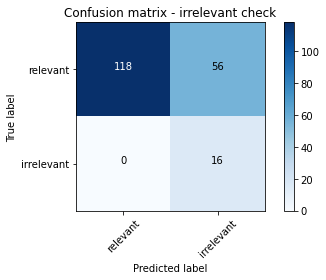

In [41]:
model_to_results('irrelevant_check')

The second model determines the quality level of the road: low vs high. The AUC and accuracy show this is slightly above random. 

Irrelevant Check Results:
AUC: 55.03 %
Accuracy: 56.19 %
Confusion matrix, without normalization
[[10 13]
 [33 49]]


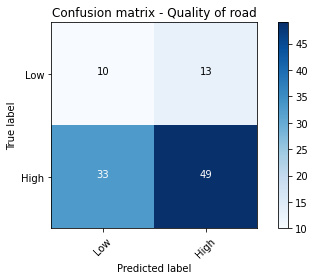

In [38]:
model_to_results('quality')

For the multitask model, the results show that the model is very good at discriminating pavement type but differencing between single car or double more, regarding street width doesn't give satisfactory results. 

This last task was therefore removed from the dataset.

Street_width Results(Multitask Model):
AUC: 66.29 %
Accuracy: 50.91 %
Pavement Type Results(Multitask Model):
AUC: 93.58 %
Accuracy: 94.55 %
Confusion matrix, without normalization
[[14 51]
 [ 3 42]]
Confusion matrix, without normalization
[[14 51  0]
 [ 3 42  0]
 [ 0  0  0]]


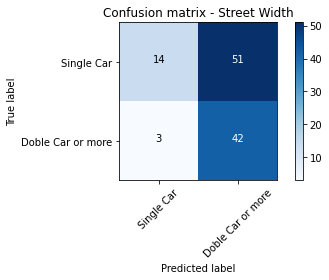

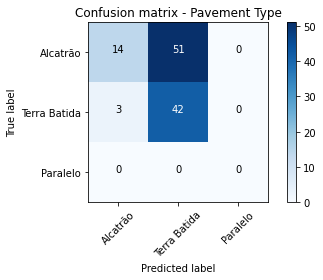

In [39]:
model_to_results('multitask')

After annotating data, we noticed a lot of variability between the four different annotators. This obviously influenced model results, as some of the classes are very hard to annotate. It is not feasible for a single person to annotate sufficient images to have a good Deep Learning model, so some variability in here is to be expected.

Specifically:
- annotating street width is very hard and depends a lot on the angle (even more for lateral images)
- annotating pavement quality is very subjective: even the same annotator, on two different day

If more images are annotated,  label errors can be slightly mitigated. 

### Model Inferencing on complete dataset

In [ ]:
# Map pavement type and quality names into risk scores 
pavement_type_risk_scores = {
    'alcatrao': 0,
    'terra_batida': 1,
    'paralelo': 2
}

pavement_quality_risk_scores = {
    'low': 1,
    'high': 0
}

# Get scores for all images, so you don't need to re-run everything again
full_dataset = pd.read_csv("data/results_dataframe_final.csv")

# Join with full_dataset
full_dataset = full_dataset.merge(car_counts_df, how="left", on="image").reset_index()

# Rearrange some of the names
full_dataset.image = full_dataset.image.str.replace('votingImage', 'vimage')

# Get images by group
full_dataset['image_group'] = full_dataset['image'].str.extract(r"(v?image\d{1,})")
full_dataset.head()

# Sanity-check print; should output: (10000, 12)
# print(full_dataset.shape)

In [ ]:
# Map the number of cars to a new column called "has_cars"
# Which tells us if we have cars in that place
full_dataset["has_cars"] = (full_dataset["nr_cars"] > 0).astype(int)

In [ ]:
# Get scores based predictions
# Pavement Type/Quality/Has Car Risk Scores
full_dataset['pavement_type_risk_score'] = full_dataset['pavement_type'].map(pavement_type_risk_scores)
full_dataset['pavement_quality_risk_scores'] = full_dataset['pavement_quality'].map(pavement_quality_risk_scores)

In [ ]:
# Compute Scores for each individual scores for each image
#full_dataset['total_score'] = full_dataset['pavement_type_risk_score'] * full_dataset['pavement_type_max_prob'] +\
#    full_dataset['pavement_quality_risk_scores']*full_dataset['quality_prob'] + full_dataset['has_car_risk_scores']

full_dataset['has_car_risk_scores'] = full_dataset['has_cars']
full_dataset['total_score'] = full_dataset['pavement_type_risk_score']  +\
    full_dataset['pavement_quality_risk_scores'] + full_dataset['has_car_risk_scores']
scores_dataset = full_dataset.copy()[["image", "image_group", "is_irrelevant_class", "pavement_type", "pavement_type_risk_score", "pavement_quality","pavement_quality_risk_scores", "has_cars", "has_car_risk_scores", "total_score"]]

In [ ]:
full_dataset.head(3)

In [ ]:
# Get scores per image group
score_per_image_group = scores_dataset.copy().groupby('image_group')['total_score'].mean().reset_index()

In [ ]:
# Open mapping image coords
mapping_name_coords = mapping_name_coords[["name", "coordinates", "freguesia", "concelho", "cidade"]]
mapping_name_coords['name'] = mapping_name_coords['name'].str.replace('votingImage', 'vimage')
mapping_name_coords["image_group"] = mapping_name_coords['name'].str.replace('votingImage', 'vimage')
mapping_name_coords
# mapping_name_coords.tail()

In [ ]:
# Join with a dataframe mapping image name to location and population density
score_per_image_group = score_per_image_group.merge(mapping_name_coords, how="left", on=['image_group'])
score_per_image_group



In [ ]:
scores_dataset[scores_dataset.image_group == 'image97']

In [ ]:
import branca.colormap as cm 
from collections import defaultdict
from folium.plugins import HeatMap

score_per_image_group['coordinates'] = score_per_image_group['coordinates'].str.replace('(', '').str.replace(')', '').str.replace('\'', '')
score_per_image_group[['latitude','longitude']] = score_per_image_group.coordinates.str.split(",",expand=True,).astype(float)

m = folium.Map(location=[38.7071,-9.13549], zoom_start=12)

steps=10
color_map=cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)
    
tmp = list(zip(
    score_per_image_group.latitude.values.astype(float),
    score_per_image_group.longitude.values.astype(float),
    score_per_image_group.total_score.values.astype(float)
))

heatmap = HeatMap(
list(zip(
    score_per_image_group.latitude.values.astype(float),
    score_per_image_group.longitude.values.astype(float),
    score_per_image_group.total_score.values.astype(float)
)), gradient = gradient_map, radius=7)

color_map.add_to(m)
heatmap.add_to(m)

for row in list(ciclovias_df['swapped_coords']):
    folium.PolyLine(locations=[row], color="blue", weight=2.5, opacity=1).add_to(m)

m

In [ ]:
# conclusões não suportam a construção de ciclovias, seriam precisos metadados extra sobre as estradas para perceber o impacto das ciclovias 

In [ ]:
def plot_quality_level(scores_dataset, image_group_name):
    
    scores_subset = scores_dataset[scores_dataset.image_group == image_group_name]
    images_in_group = list(scores_subset['image'])
    
    classification_str = []
    for i, row in scores_subset.iterrows():

        pavement_type = row['pavement_type']
        is_irrelevant = row['is_irrelevant_class']
        pavement_quality = row['pavement_quality']
        score = f'\nis_irrelevant={is_irrelevant}\n_pavement_type_{pavement_type}\n_pavement_quality_{pavement_quality}'
        classification_str.append(score)

    images = [plt.imread(IMAGES_PATH + x) for x in images_in_group]
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(images[i])
        plt.title('Image: {}'.format(classification_str[i]))

    plt.suptitle(f'Different angles for {image_group_name}')
    plt.show()


In [ ]:
score_per_image_group[~score_per_image_group.image_group.str.contains('v')].sort_values(by='total_score')

In [ ]:
plot_quality_level(scores_dataset, 'image1079')

In [ ]:
plot_quality_level(scores_dataset, 'image917')

In [ ]:
scores_dataset.is_irrelevant_class.mean()

In [ ]:
plot_quality_level(scores_dataset, 'image130')

In [ ]:
plot_quality_level(scores_dataset, 'image858')

## Conclusions

Scalability and Impact


## Future Work

Available data:

- Using a proxy task to predict danger level, such as the number of bicycle incidents in a certain region
- Adding weather data, to correlate street deterioration with weather

Further technical developments: 
- Doing cross validation at a geographical level: we may have some model bias as some areas might have lower/higher quality than others
- Segmenting road before classification (would require more annotations)